Change Noddy input file and recompute model
===========================================

In this section, we will briefly present possibilities to access the properties defined in the Noddy history input file and show how simple adjustments can be performed, for example changing the cube size to obtain a model with a higher resolution.

Also outlined here is the way that events are stored in the history file as single objects. For more information on accessing and changing the events themselves, please be patient until we get to the next section.

In [1]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [7]:
cd ../docs/notebooks/

/Users/flow/git/pynoddy/docs/notebooks


In [8]:
%matplotlib inline

In [20]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy
import pynoddy.history
import pynoddy.output

First step: load the history file into a Python object:

In [10]:
# Change to sandbox directory to store results
os.chdir(os.path.join(repo_path, 'sandbox'))
# Path to exmaple directory in this repository
example_directory = os.path.join(repo_path,'examples')
# Compute noddy model for history file
history_file = 'simple_two_faults.his'
history = os.path.join(example_directory, history_file)
output_name = 'noddy_out'
H1 = pynoddy.history.NoddyHistory(history)

**Technical note**: the `NoddyHistory` class can be accessed on the level of pynoddy (as it is imported in the `__init__.py` module) with the shortcut:

`H1 = pynoddy.NoddyHistory(history)`

I am using the long version `pynoddy.history.NoddyHistory` here to ensure that the correct package is loaded with the `reload()` function. If you don't make changes to any of the pynoddy files, this is not required. So for any practical cases, the shortcuts are absolutely fine!

Get basic information on the model
-----------------------------------

The history file contains the entire information on the Noddy model. Some information can be accessed through the NoddyHistory object (and more will be added soon!), for example the total number of events:

In [11]:
print("The history contains %d events" % H1.n_events)

The history contains 3 events


Events are implemented as objects, the classes are defined in `H1.events`. All events are accessible in a list on the level of the history object:


In [12]:
H1.events

{1: <pynoddy.events.Stratigraphy at 0x103ac2a50>,
 2: <pynoddy.events.Fault at 0x103ac2a90>,
 3: <pynoddy.events.Fault at 0x103ac2ad0>}

The properties of an event are stored in the event objects themselves. To date, only a subset of the properties (deemed as relevant for the purpose of pynoddy so far) are parsed. The .his file contains a lot more information! If access to this information is required, adjustments in pynoddy.events have to be made.

For example, the properties of a fault object are:

In [13]:
H1.events[2].properties
# print H1.events[5].properties.keys()

{'Amplitude': 2000.0,
 'Blue': 254.0,
 'Color Name': 'Custom Colour 8',
 'Cyl Index': 0.0,
 'Dip': 60.0,
 'Dip Direction': 90.0,
 'Geometry': 'Translation',
 'Green': 0.0,
 'Movement': 'Hanging Wall',
 'Pitch': 90.0,
 'Profile Pitch': 90.0,
 'Radius': 1000.0,
 'Red': 0.0,
 'Rotation': 30.0,
 'Slip': 1000.0,
 'X': 5500.0,
 'XAxis': 2000.0,
 'Y': 3968.0,
 'YAxis': 2000.0,
 'Z': 0.0,
 'ZAxis': 2000.0}

Change model cube size and recompute model
------------------------------------------

The Noddy model itself is, once computed, a continuous model in 3-D space. However, for most visualisations and further calculations (e.g. geophysics), a discretised version is suitable. The discretisation (or block size) can be adapted in the history file. The according pynoddy function is change_cube_size. 

A simple example to change the cube size and write a new history file:

In [14]:
# We will first recompute the model and store results in an output file for comparison
NH1 = pynoddy.history.NoddyHistory(history)
pynoddy.compute_model(history, output_name) 
NO1 = pynoddy.output.NoddyOutput(output_name)

In [15]:
# Now: change cubsize, write to new file and recompute
NH1.change_cube_size(50)
# Save model to a new history file and recompute (Note: may take a while to compute now)
new_history = "fault_model_changed_cubesize.his"
new_output_name = "noddy_out_changed_cube"
NH1.write_history(new_history)
pynoddy.compute_model(new_history, new_output_name)
NO2 = pynoddy.output.NoddyOutput(new_output_name)

The different cell sizes are also represented in the output files:

In [16]:
print("Model 1 contains a total of %7d cells with a blocksize %.0f m" %
      (NO1.n_total, NO1.delx))
print("Model 2 contains a total of %7d cells with a blocksize %.0f m" %
      (NO2.n_total, NO2.delx)) 

Model 1 contains a total of  582800 cells with a blocksize 100 m
Model 2 contains a total of 4662400 cells with a blocksize 50 m


We can compare the effect of the different model discretisations in section plots, created with the plot_section method described before. Let's get a bit more fancy here and use the functionality to pass axes to the plot_section method, and to create one figure as direct comparison:

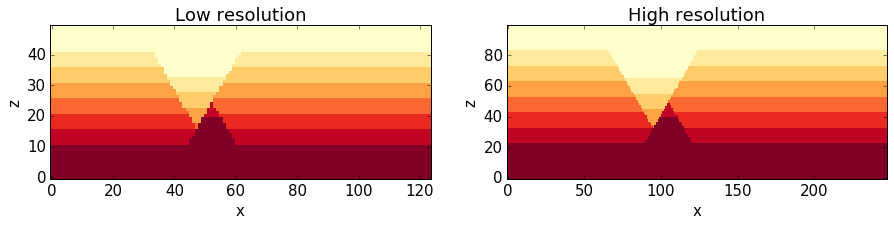

In [17]:
# create basic figure layout
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
NO1.plot_section('y', position=0, ax = ax1, colorbar=False, title="Low resolution")
NO2.plot_section('y', position=1, ax = ax2, colorbar=False, title="High resolution")

plt.show()


Note: the following two subsections contain some slighly advanced examples on how to use the possibility to adjust cell sizes through scripts directly to autmote processes that are infeasible using the GUI version of Noddy - as a 'peek preview' of the automation for uncertainty estimation that follows in a later section. Feel free to skip those two sections if you are only interested in the basic features so far.

Estimating computation time for a high-resolution model
--------------------------------------------------------

You surely realised (if you ran these examples in an actual interactive ipython notebook) that the computation of the high-resolution model takes siginificantly longer than the low-resolution model. In a practical case, this can be very important. 

In [18]:
# We use here simply the time() function to evaulate the simualtion time.
# This is not the best possible way to do it, but probably the simplest.
import time
start_time = time.time()
pynoddy.compute_model(history, output_name) 
end_time = time.time()

print("Simulation time for low-resolution model: %5.2f seconds" % (end_time - start_time))

start_time = time.time()
pynoddy.compute_model(new_history, new_output_name)
end_time = time.time()

print("Simulation time for high-resolution model: %5.2f seconds" % (end_time - start_time))


Simulation time for low-resolution model:  0.73 seconds
Simulation time for high-resolution model:  5.78 seconds


For an estimation of required computing time for a given discretisation, let's evaulate the time for a couple of steps, plot, and extrapolate:

In [21]:
# perform computation for a range of cube sizes
cube_sizes = np.arange(200,49,-5)
times = []
NH1 = pynoddy.history.NoddyHistory(history)
tmp_history = "tmp_history"
tmp_output = "tmp_output"
for cube_size in cube_sizes:
    NH1.change_cube_size(cube_size)
    NH1.write_history(tmp_history)
    start_time = time.time()
    pynoddy.compute_model(tmp_history, tmp_output)
    end_time = time.time()
    times.append(end_time - start_time)
times = np.array(times)


(200.0, 40.0)

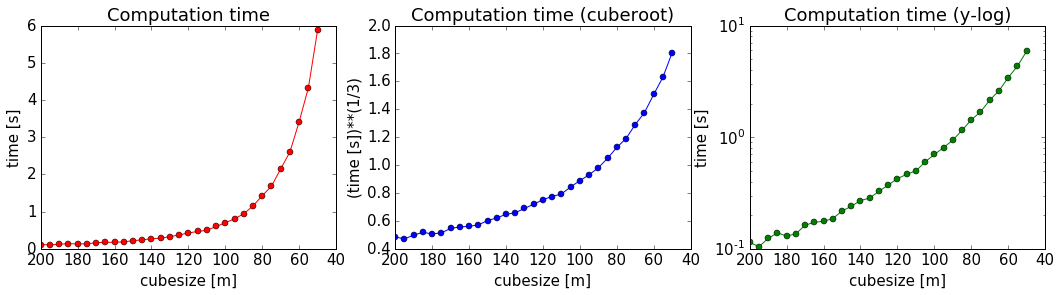

In [22]:
# create plot 
fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(cube_sizes, np.array(times), 'ro-')
ax1.set_xlabel('cubesize [m]')
ax1.set_ylabel('time [s]')
ax1.set_title('Computation time')
ax1.set_xlim(ax1.get_xlim()[::-1])

ax2.plot(cube_sizes, times**(1/3.), 'bo-')
ax2.set_xlabel('cubesize [m]')
ax2.set_ylabel('(time [s])**(1/3)')
ax2.set_title('Computation time (cuberoot)')
ax2.set_xlim(ax2.get_xlim()[::-1])

ax3.semilogy(cube_sizes, times, 'go-')
ax3.set_xlabel('cubesize [m]')
ax3.set_ylabel('time [s]')
ax3.set_title('Computation time (y-log)')
ax3.set_xlim(ax3.get_xlim()[::-1])

It is actually quite interesting that the computation time does not scale with cubesize to the power of three (as could be expected, given that we have a mesh in three dimensions). Or am I missing something?

Anyway, just because we can: let's assume that the scaling is somehow exponential and try to fit a model for a time prediction. Given the last plot, it looks like we could fit a logarithmic model with probably an additional exponent (as the line is obviously not straight), so something like:

$$ f(x) = a + \left( b \log_{10}(x) \right)^{-c} $$

Let's try to fit the curve with `scipy.optimize.curve_fit`:

In [28]:
# perform curve fitting with scipy.optimize
import scipy.optimize
# define function to be fit
def func(x,a,b,c):
    return a + (b*np.log10(x))**(-c)

popt, pcov = scipy.optimize.curve_fit(func, cube_sizes, np.array(times), p0 = [-1, 0.5, 2])
popt

array([ -0.05618538,   0.50990774,  12.45183398])

Interesting, it looks like Noody scales with something like:

$$ f(x) = \left( 0.5 \log_{10}(x) \right)^{-12} $$

**Note**: if you understand more about computational complexity than me, it might not be that interesting to you at all - if this is the case, please contact me and tell me why this result could be expected...

(200.0, 20.0)

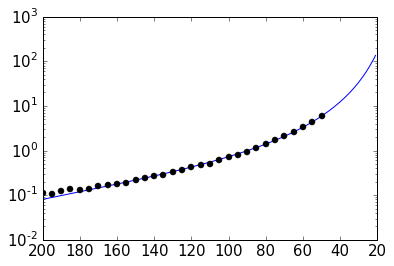

In [30]:
a,b,c = popt
cube_range = np.arange(200,20,-1)
times_eval = func(cube_range, a, b, c)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(cube_range, times_eval, '-')
ax.semilogy(cube_sizes, times, 'ko')
# reverse x-axis
ax.set_xlim(ax.get_xlim()[::-1])

Not too bad... let's evaluate the time for a cube size of 40 m:

In [31]:
cube_size = 40 # m
time_est = func(cube_size, a, b, c)
print("Estimated time for a cube size of %d m: %.1f seconds" % (cube_size, time_est))

Estimated time for a cube size of 40 m: 12.4 seconds


Now let's check the actual simulation time:

In [32]:
NH1.change_cube_size(cube_size)
NH1.write_history(tmp_history)
start_time = time.time()
pynoddy.compute_model(tmp_history, tmp_output)
end_time = time.time()
time_comp = end_time - start_time

print("Actual computation time for a cube size of %d m: %.1f seconds" % (cube_size, time_comp))

Actual computation time for a cube size of 40 m: 11.6 seconds


Not too bad, probably in the range of the inherent variability... and if we check it in the plot:

(200.0, 20.0)

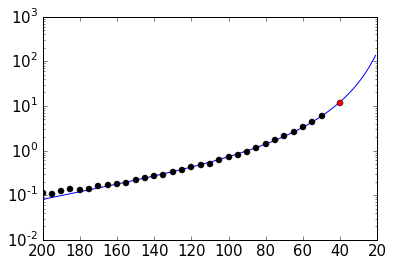

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(cube_range, times_eval, '-')
ax.semilogy(cube_sizes, times, 'ko')
ax.semilogy(cube_size, time_comp, 'ro')
# reverse x-axis
ax.set_xlim(ax.get_xlim()[::-1])

Anyway, the point of this excercise was not a precise evaluation of Noddy's computational complexity, but to provide a simple means of evaluating computation time for a high resolution model, using the flexibility of writing simple scripts using pynoddy, and a couple of additional python modules. 

For a realistic case, it should, of course, be sufficient to determine the time based on a lot less computed points. If you like, test it with your favourite model and tell me if it proved useful (or not)!

Simple convergence study
-----------------------------------------

So: why would we want to run a high-resolution model, anyway? Well, of course, it produces nicer pictures - but on a scientific level, that's completely irrelevant (haha, not true - so nice if it would be...). 

Anyway, if we want to use the model in a scientific study, for example to evaluate volume of specific units, or to estimate the geological topology (Mark is working on this topic with some cool ideas - example to be implemented here, "soon"), we want to know if the resolution of the model is actually high enough to produce meaningful results.

As a simple example of the evaluation of model resolution, we will here inlcude a volume convergence study, i.e. we will estimate at which level of increasing model resolution the estimated block volumes do not change anymore.

The entire procedure is very similar to the computational time evaluation above, only that we now also analyse the output and determine the rock volumes of each defined geological unit:

In [34]:
# perform computation for a range of cube sizes
reload(pynoddy.output)
cube_sizes = np.arange(200,49,-5)
all_volumes = []
N_tmp = pynoddy.history.NoddyHistory(history)
tmp_history = "tmp_history"
tmp_output = "tmp_output"
for cube_size in cube_sizes:
    # adjust cube size
    N_tmp.change_cube_size(cube_size)
    N_tmp.write_history(tmp_history)
    pynoddy.compute_model(tmp_history, tmp_output)
    # open simulated model and determine volumes
    O_tmp = pynoddy.output.NoddyOutput(tmp_output)
    O_tmp.determine_unit_volumes()
    all_volumes.append(O_tmp.unit_volumes)

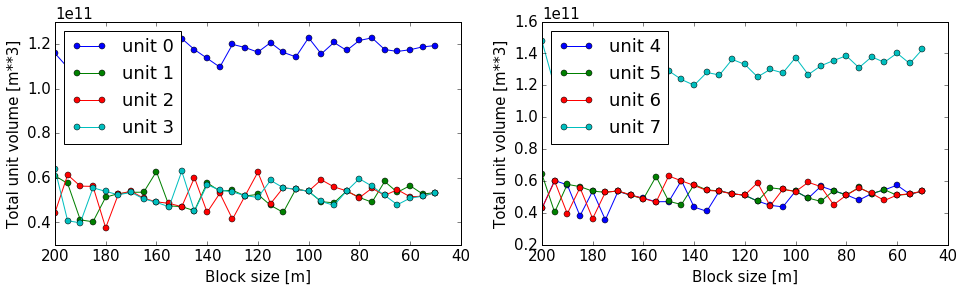

In [35]:
all_volumes = np.array(all_volumes)
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# separate into two plots for better visibility:
for i in range(np.shape(all_volumes)[1]):
    if i < 4:
        ax1.plot(cube_sizes, all_volumes[:,i], 'o-', label='unit %d' %i)
    else:
        ax2.plot(cube_sizes, all_volumes[:,i], 'o-', label='unit %d' %i)

ax1.legend(loc=2)
ax2.legend(loc=2)
# reverse axes
ax1.set_xlim(ax1.get_xlim()[::-1])
ax2.set_xlim(ax2.get_xlim()[::-1])

ax1.set_xlabel("Block size [m]")
ax1.set_ylabel("Total unit volume [m**3]")
ax2.set_xlabel("Block size [m]")
ax2.set_ylabel("Total unit volume [m**3]")

It looks like the volumes would start to converge from about a block size of 100 m. The example model is pretty small and simple, probably not the best example for this study. Try it out with your own, highly complex, favourite pet model :-)